This python script is used to load in the Harmonie data and apply the blending process using pysteps. Reading the Harmonie requires a specific engine and needs condalab to do so. This may lead to conflicting packages. Installing condalab can lead to the session crashing but that means that the kernel is restarted. After this, installing the packages is needed again.

Made by Florian Dekker and Kevin Luo

## Install required packages

In [ ]:
!pip -q install numpy matplotlib cartopy pysteps wradlib==1.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.9/568.9 kB 22.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.2/306.2 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.0 MB/s eta 0:00:00


In [ ]:
!pip install rioxarray

## Mount to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#specify the save folder
direc = '/content/drive/MyDrive/'

Mounted at /content/drive


## Import the required packages

In [ ]:
import numpy as np
import pyproj
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean, resize_local_mean
import matplotlib.pyplot as plt
import os
from datetime import date,datetime, timedelta
from scipy.ndimage import map_coordinates

from pysteps.visualization.precipfields import plot_precip_field
import h5py
from pysteps import io, motion
import wradlib
from pysteps.utils import conversion
from pysteps.verification.interface import get_method
from pysteps import nowcasts
from scipy.stats import rankdata

import xarray as xr
import rioxarray

import google.colab.files
from google.colab import files

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



## Specify the date

In [ ]:
# Specify the date and time. 5 hours after Harmonie data is made available (at 05:00, 11:00, 17:00 and 23:00)
startdatum = '202406161100'

In [ ]:
# Create folder name, where the output will be stored in
folder_name = "202406160600"

In [ ]:
# Define the starting time
start_timestamp = datetime.strptime(startdatum, '%Y%m%d%H%M')

# Define the total timespan
increment_minutes = 15
total_duration_hours = 8

num_increments = total_duration_hours * 60 // increment_minutes

base_filename = 'RAD_NL25_PCP_NA_{}.h5'

# Function to generate the filename based on the timestamp
def generate_filename(timestamp):
    return base_filename.format(timestamp.strftime('%Y%m%d%H%M'))

# Initialize the file list
file_list = []

# Loop to generate the filenames
for i in range(num_increments + 1):  # +1 to include the last timestamp within the 8 hours
    current_timestamp = start_timestamp + timedelta(minutes=i * increment_minutes)
    filename = generate_filename(current_timestamp)
    file_list.append(filename)

print(file_list)


['RAD_NL25_PCP_NA_202406161100.h5', 'RAD_NL25_PCP_NA_202406161115.h5', 'RAD_NL25_PCP_NA_202406161130.h5', 'RAD_NL25_PCP_NA_202406161145.h5', 'RAD_NL25_PCP_NA_202406161200.h5', 'RAD_NL25_PCP_NA_202406161215.h5', 'RAD_NL25_PCP_NA_202406161230.h5', 'RAD_NL25_PCP_NA_202406161245.h5', 'RAD_NL25_PCP_NA_202406161300.h5', 'RAD_NL25_PCP_NA_202406161315.h5', 'RAD_NL25_PCP_NA_202406161330.h5', 'RAD_NL25_PCP_NA_202406161345.h5', 'RAD_NL25_PCP_NA_202406161400.h5', 'RAD_NL25_PCP_NA_202406161415.h5', 'RAD_NL25_PCP_NA_202406161430.h5', 'RAD_NL25_PCP_NA_202406161445.h5', 'RAD_NL25_PCP_NA_202406161500.h5', 'RAD_NL25_PCP_NA_202406161515.h5', 'RAD_NL25_PCP_NA_202406161530.h5', 'RAD_NL25_PCP_NA_202406161545.h5', 'RAD_NL25_PCP_NA_202406161600.h5', 'RAD_NL25_PCP_NA_202406161615.h5', 'RAD_NL25_PCP_NA_202406161630.h5', 'RAD_NL25_PCP_NA_202406161645.h5', 'RAD_NL25_PCP_NA_202406161700.h5', 'RAD_NL25_PCP_NA_202406161715.h5', 'RAD_NL25_PCP_NA_202406161730.h5', 'RAD_NL25_PCP_NA_202406161745.h5', 'RAD_NL25_PCP_NA_20

## Specify the timestamps

In [ ]:
from datetime import datetime, timedelta
start_datetime = datetime.strptime(startdatum, '%Y%m%d%H%M')

# Add 5 minutes to the datetime object
file_datetime = start_datetime + timedelta(minutes=5)

file_list[0] = file_datetime.strftime('RAD_NL25_PCP_NA_%Y%m%d%H%M.h5')

In [ ]:
file_list = file_list[0:len(file_list)-2]

In [ ]:
file_list

['RAD_NL25_PCP_NA_202406161105.h5',
 'RAD_NL25_PCP_NA_202406161115.h5',
 'RAD_NL25_PCP_NA_202406161130.h5',
 'RAD_NL25_PCP_NA_202406161145.h5',
 'RAD_NL25_PCP_NA_202406161200.h5',
 'RAD_NL25_PCP_NA_202406161215.h5',
 'RAD_NL25_PCP_NA_202406161230.h5',
 'RAD_NL25_PCP_NA_202406161245.h5',
 'RAD_NL25_PCP_NA_202406161300.h5',
 'RAD_NL25_PCP_NA_202406161315.h5',
 'RAD_NL25_PCP_NA_202406161330.h5',
 'RAD_NL25_PCP_NA_202406161345.h5',
 'RAD_NL25_PCP_NA_202406161400.h5',
 'RAD_NL25_PCP_NA_202406161415.h5',
 'RAD_NL25_PCP_NA_202406161430.h5',
 'RAD_NL25_PCP_NA_202406161445.h5',
 'RAD_NL25_PCP_NA_202406161500.h5',
 'RAD_NL25_PCP_NA_202406161515.h5',
 'RAD_NL25_PCP_NA_202406161530.h5',
 'RAD_NL25_PCP_NA_202406161545.h5',
 'RAD_NL25_PCP_NA_202406161600.h5',
 'RAD_NL25_PCP_NA_202406161615.h5',
 'RAD_NL25_PCP_NA_202406161630.h5',
 'RAD_NL25_PCP_NA_202406161645.h5',
 'RAD_NL25_PCP_NA_202406161700.h5',
 'RAD_NL25_PCP_NA_202406161715.h5',
 'RAD_NL25_PCP_NA_202406161730.h5',
 'RAD_NL25_PCP_NA_2024061617

## Convert KNMI files

This part converts the radar data (in dBZ) to precipitation rates (in mm/h). Adapted from Joep Bosdijk and adjusted for this thesis.

In [ ]:
direc = '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete/'

# convert knmi_files to mm/h
def boolstr_to_floatstr(v):
    if v == True:
        return 0
    else:
        return 1

fns_file = []
for n in range(len(file_list)):
  fns_file.append(direc+ '/'+ file_list[n])

fns = []
fns.append(fns_file)
fns.append('202405250050231231231129837102983012890387')
print(fns)

path_fmt = 'KNMI_Complete/'

importer_name = 'knmi_hdf5'
importer_kwargs = {'accutime': 5, 'qty': 'DBZH', 'pixelsize': 1000.0}

importer = io.get_method(importer_name, "importer")
R, _, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

R[np.isnan(R)] = 0

# Apply Gabella filter
clutter = []
for i,j in enumerate(R):
    clutter.append(wradlib.clutter.filter_gabella(img=R[i,:,:], wsize=5))

# create binary matrix fro true/false matrix
clutter = np.vectorize(boolstr_to_floatstr)(clutter).astype(float)

#multiply binary matrix with rain rate matrix to set the clutter pixels to 0.
R = np.multiply(R,clutter)

#Convert to rain rate
R, metadata = conversion.to_rainrate(R, metadata)


[['/content/drive/MyDrive/Colab Notebooks/KNMI_Complete//RAD_NL25_PCP_NA_202406161105.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete//RAD_NL25_PCP_NA_202406161115.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete//RAD_NL25_PCP_NA_202406161130.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete//RAD_NL25_PCP_NA_202406161145.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete//RAD_NL25_PCP_NA_202406161200.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete//RAD_NL25_PCP_NA_202406161215.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete//RAD_NL25_PCP_NA_202406161230.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete//RAD_NL25_PCP_NA_202406161245.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete//RAD_NL25_PCP_NA_202406161300.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete//RAD_NL25_PCP_NA_202406161315.h5', '/content/drive/MyDrive/Colab Notebooks/KNMI_Complete//RAD_NL25_PCP_NA_202406161330.h5', '/content/drive/MyD

In [ ]:
metadata

{'projection': '+proj=stere +lat_0=90 +lon_0=0.0 +lat_ts=60.0 +a=6378137 +b=6356752 +x_0=0 +y_0=0',
 'x1': 0.0,
 'y1': -4414999.289971201,
 'x2': 700001.8290865897,
 'y2': -3649995.4110607,
 'xpixelsize': 1000.0,
 'ypixelsize': 1000.0,
 'cartesian_unit': 'm',
 'yorigin': 'upper',
 'institution': 'KNMI - Royal Netherlands Meteorological Institute',
 'accutime': 5,
 'unit': 'mm/h',
 'transform': None,
 'zerovalue': 0.0,
 'threshold': 0.0003918377307968165,
 'zr_a': 200.0,
 'zr_b': 1.6,
 'timestamps': array(['2', '0', '2', '4', '0', '5', '2', '5', '0', '0', '5', '0', '2',
        '3', '1', '2', '3', '1', '2', '3', '1', '1', '2', '9', '8', '3',
        '7', '1', '0', '2', '9'], dtype='<U1')}

## Create array with the actual observation

In [ ]:
#Reshape
KNMI_true = np.ndarray((len(R),143,162))
for i in range(len(R)):
  KNMI_true_down = resize_local_mean(R[i], (143, 162))
  KNMI_true[i] = KNMI_true_down

In [ ]:
#Save precipitation
import google.colab.files
from google.colab import files
np.save('/content/drive/MyDrive/Colab Notebooks/Resultaten/' + folder_name + f'/true_{startdatum}.npy', R)
#google.colab.files.download(f'/content/true_{startdatum}.npy')

In [ ]:
#Save TRUE downsized precipitation
np.save('/content/drive/MyDrive/Colab Notebooks/Resultaten/' + folder_name + f'/true_downsized_{startdatum}.npy', KNMI_true)
#google.colab.files.download(f'/content/true_downsized_{startdatum}.npy')

## Install cfgrib for reading Harmonie data

In [ ]:
# Install conda on google colab to be able to use cfgrib for loading the harmonie cy40 data
# Note: session crashing is possible
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install -c conda-forge cfgrib

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [ ]:
#ONLY RUN THIS CODE WHEN YOUR COMPUTER CRASHED. When crashed, you can use the downloaded version of R
filename = f'true_{startdatum}.npy'
R = np.load(f'/content/{filename}')
R.shape

FileNotFoundError: [Errno 2] No such file or directory: '/content/true_202405142300.npy'

In [ ]:
start_datetime.strftime('%Y%m%d%H')

'2024061611'

## Load Harmonie data

This part loads the Harmonie data and pre-process it. The Harmonie data covers Europe and needs to be clipped to The Netherlands. This part is made for this thesis project.

In [ ]:
# Initialize an empty list to hold the datasets
datasets = []

# Initialize an empty list to hold the extracted arrays
extracted_arrays = []

# Iterate over the range of file numbers
for i in range(100, 2901, 100):
    # Generate the file path
    file_path = f"/content/drive/MyDrive/Colab Notebooks/harm40_v1_p3_{(start_datetime-timedelta(hours=5)).strftime('%Y%m%d%H')}/HA40_N55_{(start_datetime-timedelta(hours=5)).strftime('%Y%m%d%H')}00_{i:05d}_GB"
    print(file_path)
    # Open the dataset
    ds = xr.open_dataset(file_path, engine='cfgrib', backend_kwargs={'filter_by_keys': {'indicatorOfParameter': 181, 'stepType': 'instant'}})

    # Bounding box (same as radar_reflectivity_composites)
    minlon = 0.0
    maxlon = 10.86
    minlat = 48.9
    maxlat = 55.97

    # Set coordinates and clip the dataset
    ds = ds.set_coords(['latitude', 'longitude'])
    ds = ds.assign_coords({"x": ds.longitude[0, :], "y": ds.latitude[:, 0]})
    ds = ds.drop_vars(['latitude', 'longitude'])
    ds = ds.rio.write_crs("epsg:4326",inplace=True)
    ds = ds.rio.clip_box(minx=minlon, miny=minlat, maxx=maxlon, maxy=maxlat)

    # Extract the 'unknown' variable and convert to mm/h
    unknown_array = ds['unknown'].values*3600

    # Append the dataset and the extracted array to their respective lists
    datasets.append(ds)
    extracted_arrays.append(unknown_array)

# Convert the list of arrays to a single numpy array
extracted_array_combined = np.stack(extracted_arrays)

print("Shape of combined array:", extracted_array_combined.shape)

/content/drive/MyDrive/Colab Notebooks/harm40_v1_p3_2024051418/HA40_N55_202405141800_00100_GB


ValueError: unrecognized engine cfgrib must be one of: ['netcdf4', 'h5netcdf', 'scipy', 'radolan', 'store', 'wradlib-cfradial1', 'wradlib-cfradial2', 'wradlib-furuno', 'wradlib-gamic', 'wradlib-iris', 'wradlib-odim', 'wradlib-rainbow']

In [ ]:
# This line is needed if the extracted_array_combined is created in another notebook and needed to be loaded in this notebook
# This was needed in cases where the condacolab and cfgrib packages where conflicting

# extracted_array_combined = np.load('/content/drive/MyDrive/Colab Notebooks/NWP/nwp_2024061606.npy')

In [ ]:
extracted_array_combined.shape

(29, 143, 162)

## Interpolate Harmonie data

This part describes the function used for interpolating the Harmonie data from 1 hour to every 15 minutes. The function advection_correction is from pysteps and is adjusted for the needs of this thesis project. The adjustment ensures that the output is an array with the original data and the interpolated data.

In [ ]:
def advection_correction(R, T=60, t=15):
    """
    R = np.array([qpe_previous, qpe_current])
    T = time between two observations (60 min)
    t = interpolation timestep (15 min)
    """

    # Evaluate advection
    oflow_method = motion.get_method("LK")
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects
    V = oflow_method(np.log(R), fd_kwargs=fd_kwargs)

#This part is added for this thesis project

    # Number of intervals, including the final timestamp T
    num_intervals = T // t

    # Prepare the array to store interpolated results
    Rd_all = np.zeros((num_intervals - 1, *R[0].shape))

    x, y = np.meshgrid(
        np.arange(R[0].shape[1], dtype=float), np.arange(R[0].shape[0], dtype=float)
    )
# From here, it is taken from the original code of pysteps

    for idx, i in enumerate(range(t, T, t)):
        pos1 = (y - i / T * V[1], x - i / T * V[0])
        R1 = map_coordinates(R[0], pos1, order=1)

        pos2 = (y + (T - i) / T * V[1], x + (T - i) / T * V[0])
        R2 = map_coordinates(R[1], pos2, order=1)

        Rd = ((T - i) / T) * R1 + (i / T) * R2
        Rd_all[idx] = Rd

    return Rd_all

In [ ]:
# Create empty array to store the interpolated data
interpolated_arrays = []

# Loop through the data and combine the interpolation results with extracted_array_combined[i]
for i in range(4,12):
    interpolation = advection_correction(extracted_array_combined[i:i+2], T=60, t=15)

    # Stack extracted_array_combined[i] and interpolation along the first axis
    interpolated_array = np.concatenate(([extracted_array_combined[i]], interpolation), axis=0)

    # Append the combined array to the list
    interpolated_arrays.append(interpolated_array)

# Convert the list of arrays into a single NumPy array
nwp_all = np.concatenate(interpolated_arrays, axis=0)
nwp_all = np.concatenate((nwp_all, extracted_array_combined[12][np.newaxis, :, :]), axis=0)

In [ ]:
#Remove the last 2 so that it matches the shape of the true precipitation
nwp_all = nwp_all[0:len(nwp_all)-2]

In [ ]:
nwp_all.shape
#(31, 143, 162)

(31, 143, 162)

## DGMR downsizing

This part modifies the spatial resultion of DGMR because DGMR uses radar data with a spatial resolution of 1.0 by 1.0 km, while Harmonie has a spatial resolution of 2.5 by 2.5 km. The downsizing is done using local mean. This part is made during this thesis project.

In [ ]:
start_timestamp = datetime.strptime(startdatum, "%Y%m%d%H%M")
start_timestamp

datetime.datetime(2024, 6, 16, 11, 0)

In [ ]:
start_timestamp = datetime.strptime(startdatum, "%Y%m%d%H%M")

# List to store the loaded numpy arrays
DGMR_arrays = []
DGMR_arrays_down = []


filename = f'DGMR_{start_datetime.strftime("%Y%m%d%H")}05.npy'
file_path = f'/content/drive/MyDrive/Colab Notebooks/DGMR_{(start_datetime-timedelta(hours=5)).strftime("%Y%m%d%H%M")}/{filename}'
first_array = np.load(file_path)
first_array_down = resize_local_mean(first_array, (143, 162))
DGMR_arrays.append(first_array)
DGMR_arrays_down.append(first_array_down)

# Load the arrays for 8 hours starting from the initial timestamp
for i in range(1,8*4-2):
    # Calculate the new timestamp
    timestamp = start_timestamp + timedelta(minutes=i*15)
    # Format the timestamp as a string
    filename = timestamp.strftime("DGMR_%Y%m%d%H%M.npy")
    # Construct the full file path
    file_path = f'/content/drive/MyDrive/Colab Notebooks/DGMR_{(start_datetime-timedelta(hours=5)).strftime("%Y%m%d%H%M")}/{filename}'
    # Load the numpy array
    DGMR_array = np.load(file_path)

    #downsampled
    DGMR_array_down = resize_local_mean(DGMR_array, (143, 162))
    # Append the array to the list
    DGMR_arrays.append(DGMR_array)
    DGMR_arrays_down.append(DGMR_array_down)
    print(f"Loaded {filename}")

# Optionally, convert the list to a numpy array for further processing
DGMR_combined = np.array(DGMR_arrays)
DGMR_combined_down = np.array(DGMR_arrays_down)

# Print the shape of the combined array to confirm
print(DGMR_combined.shape)

#repeat the last DGMR a couple of times
last_array = DGMR_combined[-1]
last_down_array = DGMR_combined_down[-1]
repeated_arrays = np.tile(last_array, (1, 1, 1))
repeated_down_arrays = np.tile(last_down_array, (1, 1, 1))

# Concatenate the original and repeated arrays
DGMR_combined_extended = np.concatenate((DGMR_combined, repeated_arrays), axis=0)
#This is the downsampled one that you want to use as the nowcast
DGMR_combined_extended_down = np.concatenate((DGMR_combined_down, repeated_down_arrays), axis=0)

print(DGMR_combined_extended.shape)
print(DGMR_combined_extended_down.shape)

Loaded DGMR_202406161115.npy
Loaded DGMR_202406161130.npy
Loaded DGMR_202406161145.npy
Loaded DGMR_202406161200.npy
Loaded DGMR_202406161215.npy
Loaded DGMR_202406161230.npy
Loaded DGMR_202406161245.npy
Loaded DGMR_202406161300.npy
Loaded DGMR_202406161315.npy
Loaded DGMR_202406161330.npy
Loaded DGMR_202406161345.npy
Loaded DGMR_202406161400.npy
Loaded DGMR_202406161415.npy
Loaded DGMR_202406161430.npy
Loaded DGMR_202406161445.npy
Loaded DGMR_202406161500.npy
Loaded DGMR_202406161515.npy
Loaded DGMR_202406161530.npy
Loaded DGMR_202406161545.npy
Loaded DGMR_202406161600.npy
Loaded DGMR_202406161615.npy
Loaded DGMR_202406161630.npy
Loaded DGMR_202406161645.npy
Loaded DGMR_202406161700.npy
Loaded DGMR_202406161715.npy
Loaded DGMR_202406161730.npy
Loaded DGMR_202406161745.npy
Loaded DGMR_202406161800.npy
Loaded DGMR_202406161815.npy
(30, 765, 700)
(31, 765, 700)
(31, 143, 162)


## Pysteps linear blending

This part shows the blending process using pysteps. The function linear_blending.forecast is adjusted from the original code of pysteps. The adjustment ensures that the nowcast is replaced by the output of DGMR.

In [ ]:
"""
pysteps.nowcasts.linear_blending
================================

Linear blending method to blend (ensemble) nowcasts and (ensemble) Numerical
Weather Prediction (NWP) forecasts. The method uses a predefined start and end
time for the blending. Before this start time, the resulting blended forecasts only
consists of the nowcast(s). In between the start and end time, the nowcast(s)
weight decreases and NWP forecasts weight increases linearly from 1(0) to
0(1). After the end time, the blended forecast entirely consists of the NWP
forecasts. The saliency-based blending method also takes into account the pixel
intensities and preserves them if they are strong enough based on their ranked salience.

Implementation of the linear blending and saliency-based blending between nowcast and NWP data.

.. autosummary::
    :toctree: ../generated/

    forecast
"""

import numpy as np
from pysteps import nowcasts
from pysteps.utils import conversion
from scipy.stats import rankdata


def forecast(
    precip,
    precip_metadata,
    timesteps,
    timestep,
    precip_nwp=None,
    precip_nwp_metadata=None,
    start_blending=120,
    end_blending=240,
    fill_nwp=True,
    saliency=False,
    nowcast_kwargs=None,
):
    """Generate a forecast by linearly or saliency-based blending of nowcasts with NWP data

    Parameters
    ----------
    precip_nowcast: array_like
      Array containing DGMR output
    precip: array_like
      Array containing the input precipitation field(s) ordered by timestamp
      from oldest to newest. The time steps between the inputs are assumed
      to be regular.
    precip_metadata: dict
        Metadata dictionary containing (at least) the transform, unit and threshold
        attributes as described in the documentation of :py:mod:`pysteps.io.importers`.
    velocity; array_like
      Array of shape (2, m, n) containing the x- and y-components of the advection
      field. The velocities are assumed to represent one time step between the
      inputs. All values are required to be finite.
    timesteps: int
      Number of time steps to forecast.
    timestep: int or float
      The time difference (in minutes) between consecutive forecast fields.
    nowcast_method: str
      Name of the nowcasting method. See :py:mod:`pysteps.nowcasts.interface`
      for the list of available methods.
    precip_nwp: array_like or NoneType, optional
      Array of shape (timesteps, m, n) in the case of no ensemble or
      of shape (n_ens_members, timesteps, m, n) in the case of an ensemble
      containing the NWP precipitation fields ordered by timestamp from oldest
      to newest. The time steps between the inputs are assumed to be regular
      (and identical to the time step between the nowcasts). If no NWP
      data is given the value of precip_nwp is None and no blending will be performed.
    precip_nwp_metadata: dict or NoneType, optional
        NWP metadata dictionary containing (at least) the transform, unit and threshold
        attributes as described in the documentation of :py:mod:`pysteps.io.importers`.
    start_blending: int, optional
      Time stamp (in minutes) after which the blending should start. Before this
      only the nowcast data is used.
    end_blending: int, optional
      Time stamp (in minutes) after which the blending should end. Between
      start_blending and end_blending the nowcasts and NWP data are linearly
      merged with each other. After end_blending only the NWP data is used.
    fill_nwp: bool, optional
      Standard value is True. If True, the NWP data will be used to fill in the
      no data mask of the nowcast.
    saliency: bool, optional
      Default value is False. If True, saliency will be used for blending. The blending
      is based on intensities and forecast times as described in :cite:`Hwang2015`. The blended
      product preserves pixel intensities with time if they are strong enough based on their ranked
      salience.
    nowcast_kwargs: dict, optional
      Dictionary containing keyword arguments for the nowcast method.


    Returns
    -------
    precip_blended: ndarray
      Array of shape (timesteps, m, n) in the case of no ensemble or
      of shape (n_ens_members, timesteps, m, n) in the case of an ensemble
      containing the precipation forecast generated by linearly blending
      the nowcasts and the NWP data. n_ens_members equals the maximum no. of
      ensemble members in either the nowcast or nwp model(s).
    """

    if nowcast_kwargs is None:
        nowcast_kwargs = dict()

# This part is adjusted so that no nowcast is generated and DGMR output is used

    precip_nowcast = precip

# From here, it follows the original code

    # # Calculate the nowcasts
    # nowcast_method_func = nowcasts.get_method(nowcast_method)
    # precip_nowcast = nowcast_method_func(
    #     precip,
    #     velocity,
    #     timesteps,
    #     **nowcast_kwargs,
    # )

    # # Make sure that precip_nowcast and precip_nwp are in mm/h
    # precip_nowcast, _ = conversion.to_rainrate(precip_nowcast, metadata=precip_metadata)

    # Check if NWP data is given as input
    if precip_nwp is not None:
        precip_nwp, _ = conversion.to_rainrate(precip_nwp, metadata=precip_nwp_metadata)

        if len(precip_nowcast.shape) == 4:
            n_ens_members_nowcast = precip_nowcast.shape[0]
            if n_ens_members_nowcast == 1:
                precip_nowcast = np.squeeze(precip_nowcast)
        else:
            n_ens_members_nowcast = 1

        if len(precip_nwp.shape) == 4:
            n_ens_members_nwp = precip_nwp.shape[0]
            if n_ens_members_nwp == 1:
                precip_nwp = np.squeeze(precip_nwp)
        else:
            n_ens_members_nwp = 1

        # Now, repeat the nowcast ensemble members or the nwp models/members until
        # it has the same amount of members as n_ens_members_max. For instance, if
        # you have 10 ensemble nowcasts members and 3 NWP members, the output will
        # be an ensemble of 10 members. Hence, the three NWP members are blended
        # with the first three members of the nowcast (member one with member one,
        # two with two, etc.), subsequently, the same NWP members are blended with
        # the next three members (NWP member one with member 4, NWP member 2 with
        # member 5, etc.), until 10 is reached.
        n_ens_members_max = max(n_ens_members_nowcast, n_ens_members_nwp)
        n_ens_members_min = min(n_ens_members_nowcast, n_ens_members_nwp)

        if n_ens_members_min != n_ens_members_max:
            if n_ens_members_nwp == 1:
                precip_nwp = np.repeat(
                    precip_nwp[np.newaxis, :, :], n_ens_members_max, axis=0
                )
            elif n_ens_members_nowcast == 1:
                precip_nowcast = np.repeat(
                    precip_nowcast[np.newaxis, :, :], n_ens_members_max, axis=0
                )
            else:
                repeats = [
                    (n_ens_members_max + i) // n_ens_members_min
                    for i in range(n_ens_members_min)
                ]

                if n_ens_members_nwp == n_ens_members_min:
                    precip_nwp = np.repeat(precip_nwp, repeats, axis=0)
                elif n_ens_members_nowcast == n_ens_members_min:
                    precip_nowcast = np.repeat(precip_nowcast, repeats, axis=0)

        # Check if dimensions are correct
        assert (
            precip_nwp.shape == precip_nowcast.shape
        ), "The dimensions of precip_nowcast and precip_nwp need to be identical: dimension of precip_nwp = {} and dimension of precip_nowcast = {}".format(
            precip_nwp.shape, precip_nowcast.shape
        )

        # Initialise output
        precip_blended = np.zeros_like(precip_nowcast)

        # Calculate the weights
        for i in range(timesteps):
            # Calculate what time we are at
            t = (i + 1) * timestep

            if n_ens_members_max == 1:
                ref_dim = 0
            else:
                ref_dim = 1

            # apply blending
            # compute the slice indices
            slc_id = _get_slice(precip_blended.ndim, ref_dim, i)

            # Calculate the weight with a linear relation (weight_nwp at start_blending = 0.0)
            # and (weight_nwp at end_blending = 1.0)
            weight_nwp = (t - start_blending) / (end_blending - start_blending)

            # Set weights at times before start_blending and after end_blending
            if weight_nwp <= 0.0:
                weight_nwp = 0.0
                precip_blended[slc_id] = precip_nowcast[slc_id]

            elif weight_nwp >= 1.0:
                weight_nwp = 1.0
                precip_blended[slc_id] = precip_nwp[slc_id]

            else:
                # Calculate weight_nowcast
                weight_nowcast = 1.0 - weight_nwp

                # Calculate output by combining precip_nwp and precip_nowcast,
                # while distinguishing between ensemble and non-ensemble methods
                if saliency:
                    ranked_salience = _get_ranked_salience(
                        precip_nowcast[slc_id], precip_nwp[slc_id]
                    )
                    ws = _get_ws(weight_nowcast, ranked_salience)
                    precip_blended[slc_id] = (
                        ws * precip_nowcast[slc_id] + (1 - ws) * precip_nwp[slc_id]
                    )

                else:
                    precip_blended[slc_id] = (
                        weight_nwp * precip_nwp[slc_id]
                        + weight_nowcast * precip_nowcast[slc_id]
                    )

            # Find where the NaN values are and replace them with NWP data
            if fill_nwp:
                nan_indices = np.isnan(precip_blended)
                precip_blended[nan_indices] = precip_nwp[nan_indices]
    else:
        # If no NWP data is given, the blended field is simply equal to the nowcast field
        precip_blended = precip_nowcast

    return precip_blended


def _get_slice(n_dims, ref_dim, ref_id):
    """source: https://stackoverflow.com/a/24399139/4222370"""
    slc = [slice(None)] * n_dims
    slc[ref_dim] = ref_id
    return tuple(slc)


def _get_ranked_salience(precip_nowcast, precip_nwp):
    """Calculate ranked salience, which show how close the pixel is to the maximum intensity difference [r(x,y)=1]
      or the minimum intensity difference [r(x,y)=0]

    Parameters
    ----------
    precip_nowcast: array_like
      Array of shape (m,n) containing the extrapolated precipitation field at a specified timestep
    precip_nwp: array_like
      Array of shape (m,n) containing the NWP fields at a specified timestep

    Returns
    -------
    ranked_salience:
      Array of shape (m,n) containing ranked salience
    """

    # calcutate normalized intensity
    if np.max(precip_nowcast) == 0:
        norm_nowcast = np.zeros_like(precip_nowcast)
    else:
        norm_nowcast = precip_nowcast / np.max(precip_nowcast)

    if np.max(precip_nwp) == 0:
        norm_nwp = np.zeros_like(precip_nwp)
    else:
        norm_nwp = precip_nwp / np.max(precip_nwp)

    diff = norm_nowcast - norm_nwp

    # Calculate ranked salience, based on dense ranking method, in which equally comparable values receive the same ranking number
    ranked_salience = rankdata(diff, method="dense").reshape(diff.shape).astype("float")
    ranked_salience /= ranked_salience.max()

    return ranked_salience


def _get_ws(weight, ranked_salience):
    """Calculate salience weight based on linear weight and ranked salience as described in :cite:`Hwang2015`.
      Cells with higher intensities result in larger weights.

    Parameters
    ----------
    weight: int
      Varying between 0 and 1
    ranked_salience: array_like
      Array of shape (m,n) containing ranked salience

    Returns
    -------
    ws: array_like
      Array of shape (m,n) containing salience weight, which preserves pixel intensties with time if they are strong
      enough based on the ranked salience.
    """

    # Calculate salience weighte
    ws = 0.5 * (
        (weight * ranked_salience)
        / (weight * ranked_salience + (1 - weight) * (1 - ranked_salience))
        + (
            np.sqrt(ranked_salience**2 + weight**2)
            / (
                np.sqrt(ranked_salience**2 + weight**2)
                + np.sqrt((1 - ranked_salience) ** 2 + (1 - weight) ** 2)
            )
        )
    )
    return ws

## Start blending



In [ ]:
radar_metadata =  {'projection': '+proj=stere +lat_0=90 +lon_0=0.0 +lat_ts=60.0 +a=6378137 +b=6356752 +x_0=0 +y_0=0',
        "x1": 110000.,
        "y1": -4304999.2899712,
        "x2": 700001.,
        "y2": -3759995.2899712,
        'xpixelsize': 1000.0,
        'ypixelsize': 1000.0,
        'cartesian_unit': 'm',
        'yorigin': 'upper',
        'institution': 'KNMI - Royal Netherlands Meteorological Institute',
        'accutime': 5,
        'unit': 'mm/h',
        'transform': None,
        'zerovalue': 0.0,
        'threshold': 0.0003918377307968165,
        'zr_a': 200.0,
        'zr_b': 1.6}

nwp_metadata =  {'projection': 'epsg4326',
        "x1": 110000.,
        "y1": -4304999.2899712,
        "x2": 700001.,
        "y2": -3759995.2899712,
        'xpixelsize': 2500.0,
        'ypixelsize': 2500.0,
        'cartesian_unit': 'm',
        'yorigin': 'upper',
        'institution': 'KNMI - Royal Netherlands Meteorological Institute',
        'accutime': 60,
        'unit': 'mm/h',
        'transform': None,
        'zerovalue': 0.0,
        'threshold': 0.0003918377307968165,
        'zr_a': 200.0,
        'zr_b': 1.6}

In [ ]:
#Download DGMR_combined_extended_down
# Save the DGMR_combined_extended_down array to a .npy file
np.save('/content/drive/MyDrive/Colab Notebooks/Resultaten/' + folder_name + f'/DGMR_combined_extended_down_{startdatum}.npy', DGMR_combined_extended_down)

# Download the file
#google.colab.files.download(f'/content/drive/MyDrive/Colab Notebooks/Resultaten/202405200600/DGMR_combined_extended_down_{startdatum}.npy')

In [ ]:
#Download NWP_all
np.save('/content/drive/MyDrive/Colab Notebooks/Resultaten/' + folder_name + f'/nwp_all_{startdatum}.npy', nwp_all)

# Download the file
#google.colab.files.download(f'/content/nwp_all_{startdatum}.npy')

In [ ]:
# Initiate linear blending
precip_blended = forecast(
    precip = DGMR_combined_extended_down,
    precip_metadata = radar_metadata,
    timesteps=31,
    timestep=15,
    precip_nwp=nwp_all,
    precip_nwp_metadata=nwp_metadata,
    start_blending=15,
    end_blending=320,
    fill_nwp=True,
    saliency=False,
    nowcast_kwargs=None,
)

In [ ]:
# Initiate salient-based linear blending
precip_salient_blended = forecast(
    precip = DGMR_combined_extended_down,
    precip_metadata = radar_metadata,
    timesteps=31,
    timestep=15,
    precip_nwp=nwp_all,
    precip_nwp_metadata=nwp_metadata,
    start_blending=15,
    end_blending=320,
    fill_nwp=True,
    saliency=True,
    nowcast_kwargs=None,
)

In [ ]:
#Download the blended forecasts
np.save('/content/drive/MyDrive/Colab Notebooks/Resultaten/' + folder_name + f'/precip_blended_{startdatum}.npy', precip_blended)

# Download the file
#google.colab.files.download(f'/content/precip_blended_{startdatum}.npy')

In [ ]:
#Download the salient forecast
np.save('/content/drive/MyDrive/Colab Notebooks/Resultaten/' + folder_name + f'/precip_salient_blended_{startdatum}.npy', precip_salient_blended)

# Download the file
#google.colab.files.download(f'/content/precip_salient_blended_{startdatum}.npy')

In [ ]:
print(R.shape,DGMR_combined_extended_down.shape, precip_blended.shape, precip_salient_blended.shape, nwp_all.shape)
#(31, 765, 700) (31, 143, 162) (31, 143, 162) (31, 143, 162) (31, 143, 162)


(31, 765, 700) (31, 143, 162) (31, 143, 162) (31, 143, 162) (31, 143, 162)


## Plot the blending output

This part visualizes the blending output. In addition, the DGMR output, Harmonie data and actual observation are added to create a comparison.

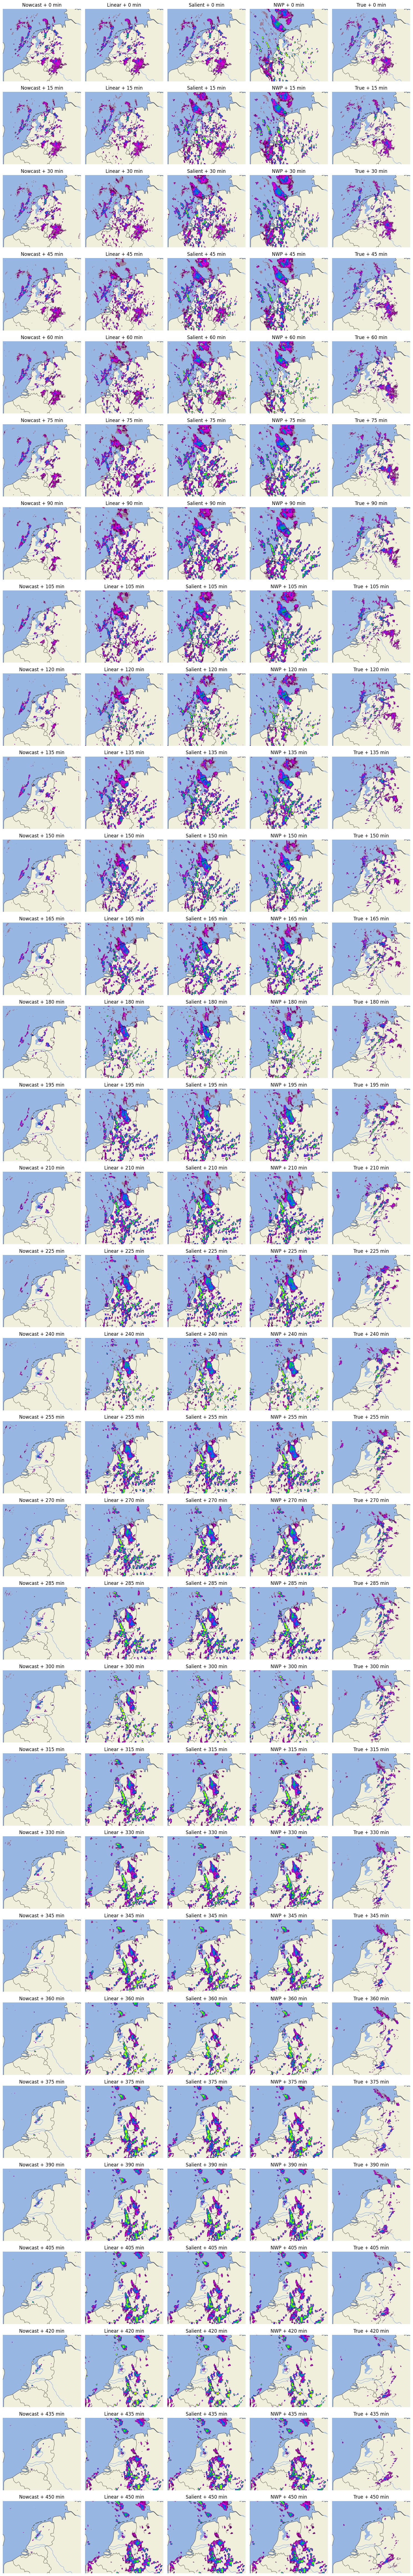

In [ ]:
import matplotlib.pyplot as plt

timestep = 15
n_leadtimes = 31
n_columns = 5

# Adjust the figure size based on the number of rows and columns
fig_height = n_leadtimes * 3
fig_width = n_columns * 3

fig = plt.figure(figsize=(fig_width, fig_height))

for n in range(n_leadtimes):
    leadtime = (n + 1) * timestep
    # Extrapolation
    plt.subplot(n_leadtimes, 5, n * 5 + 1)
    plot_precip_field(
        DGMR_combined_extended_down[int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"Nowcast + {leadtime-15} min",
        axis="off",
        colorbar=False,
    )

    # Nowcast with blending into NWP
    plt.subplot(n_leadtimes, 5, n * 5 + 2)
    plot_precip_field(
        precip_blended[int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"Linear + {leadtime-15} min",
        axis="off",
        colorbar=False,
    )

    # Nowcast with salient blending into NWP
    plt.subplot(n_leadtimes, 5, n * 5 + 3)
    plot_precip_field(
        precip_salient_blended[int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"Salient + {leadtime-15} min",
        axis="off",
        colorbar=False,
    )

    # Raw NWP forecast
    plt.subplot(n_leadtimes, 5, n * 5 + 4)
    plot_precip_field(
        nwp_all[int(leadtime / timestep) - 1, :, :],
        geodata=radar_metadata,
        title=f"NWP + {leadtime-15} min",
        axis="off",
        colorbar=False,
    )

    # True precipitation
    plt.subplot(n_leadtimes, 5, n * 5 + 5)
    plot_precip_field(
        R[int(leadtime / timestep)-1,:,:],
        geodata=radar_metadata,
        title=f"True + {leadtime-15} min",
        axis="off",
        colorbar=False,
    )

plt.tight_layout()
plt.show()


## Evaluation blending

This part describes how the probability of detection (POD), false alarm rate (DAR) and fractional skill score (FSS) are determined using pysteps.

In [ ]:
pod_method = get_method("POD", type="deterministic")
far_method = get_method("FAR", type="deterministic")
fss_method = get_method("FSS", type="deterministic")

In [ ]:
(precip_blended[0] > 0.5).sum()

635

In [ ]:
# Define precipitation rate thresholds
thresholds = [0.5, 2, 5, 10, 20, 30]  # mm/h

In [ ]:
# Adjusting the actual observation to the same spatial resolution as harmonie
KNMI_true = np.empty((R.shape[0], 143, 162))
for i in range(R.shape[0]):
    KNMI_true[i] = resize_local_mean(R[i], (143, 162))

### POD

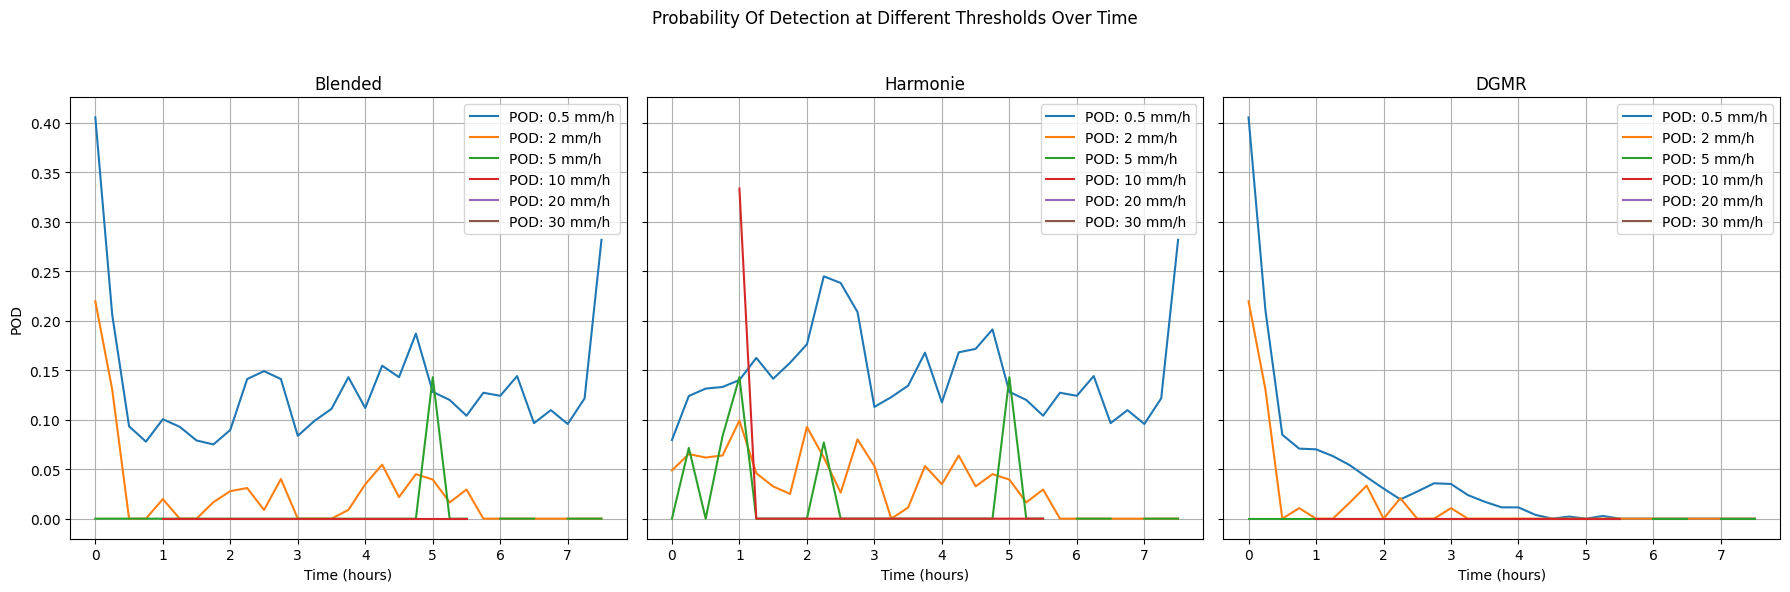

In [ ]:
datasets = ['precip_blended', 'nwp_all', 'DGMR_combined_extended_down']
pod_scores = {dataset: {thr: [] for thr in thresholds} for dataset in datasets}

# Define lead times in 15-minute increments, total of 31 lead times
lead_times = np.arange(31)  # 0 to 30 lead times

# Compute POD for each lead time, threshold, and dataset
for t in lead_times:
    for thr in thresholds:
        try:
            pod_scores['precip_blended'][thr].append(pod_method(precip_blended[t], KNMI_true[t], thr=thr)['POD'])
            pod_scores['nwp_all'][thr].append(pod_method(nwp_all[t], KNMI_true[t], thr=thr)['POD'])
            pod_scores['DGMR_combined_extended_down'][thr].append(pod_method(DGMR_combined_extended_down[t], KNMI_true[t], thr=thr)['POD'])
        except Exception as e:
            print(f"Error computing POD for lead time {t} and threshold {thr}: {e}")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Define the x-axis values in hours
time_steps_hours = lead_times * 0.25  # 15 minutes is 0.25 hours

# Plot for precip_blended
for thr in thresholds:
    axes[0].plot(time_steps_hours, pod_scores['precip_blended'][thr], label=f"POD: {thr} mm/h")
axes[0].set_title('Blended')
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("POD")
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(np.arange(0, 7.5, 1))  # Set x-ticks at 0, 1, 2, ..., 7

# Plot for nwp_all
for thr in thresholds:
    axes[1].plot(time_steps_hours, pod_scores['nwp_all'][thr], label=f"POD: {thr} mm/h")
axes[1].set_title('Harmonie')
axes[1].set_xlabel("Time (hours)")
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(np.arange(0, 7.5, 1))  # Set x-ticks at 0, 1, 2, ..., 7

# Plot for DGMR_combined_extended_down
for thr in thresholds:
    axes[2].plot(time_steps_hours, pod_scores['DGMR_combined_extended_down'][thr], label=f"POD: {thr} mm/h")
axes[2].set_title('DGMR')
axes[2].set_xlabel("Time (hours)")
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(np.arange(0, 7.5, 1))  # Set x-ticks at 0, 1, 2, ..., 7

plt.suptitle('Probability Of Detection at Different Thresholds Over Time')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### FAR

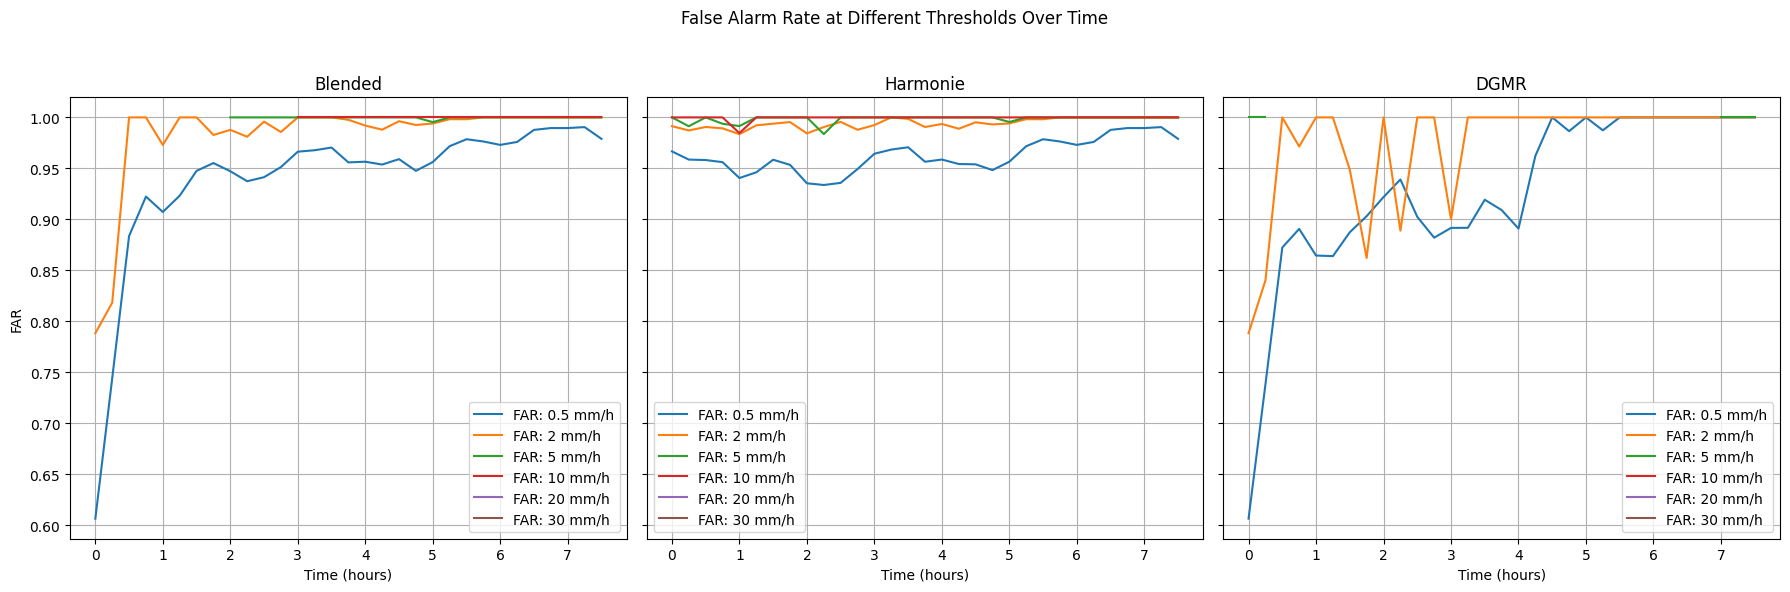

In [ ]:
datasets = ['precip_blended', 'nwp_all', 'DGMR_combined_extended_down']
far_scores = {dataset: {thr: [] for thr in thresholds} for dataset in datasets}

# Define lead times in 15-minute increments, total of 31 lead times
lead_times = np.arange(31)  # 0 to 30 lead times

# Compute FAR for each lead time, threshold, and dataset
for t in lead_times:
    for thr in thresholds:
        try:
            far_scores['precip_blended'][thr].append(far_method(precip_blended[t], KNMI_true[t], thr=thr)['FAR'])
            far_scores['nwp_all'][thr].append(far_method(nwp_all[t], KNMI_true[t], thr=thr)['FAR'])
            far_scores['DGMR_combined_extended_down'][thr].append(far_method(DGMR_combined_extended_down[t], KNMI_true[t], thr=thr)['FAR'])
        except Exception as e:
            print(f"Error computing FAR for lead time {t} and threshold {thr}: {e}")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Define the x-axis values in hours
time_steps_hours = lead_times * 0.25  # 15 minutes is 0.25 hours

# Plot for precip_blended
for thr in thresholds:
    axes[0].plot(time_steps_hours, far_scores['precip_blended'][thr], label=f"FAR: {thr} mm/h")
axes[0].set_title('Blended')
axes[0].set_xlabel("Time (hours)")
axes[0].set_ylabel("FAR")
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(np.arange(0, 7.5, 1))  # Set x-ticks at 0, 1, 2, ..., 7

# Plot for nwp_all
for thr in thresholds:
    axes[1].plot(time_steps_hours, far_scores['nwp_all'][thr], label=f"FAR: {thr} mm/h")
axes[1].set_title('Harmonie')
axes[1].set_xlabel("Time (hours)")
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(np.arange(0, 7.5, 1))  # Set x-ticks at 0, 1, 2, ..., 7

# Plot for DGMR_combined_extended_down
for thr in thresholds:
    axes[2].plot(time_steps_hours, far_scores['DGMR_combined_extended_down'][thr], label=f"FAR: {thr} mm/h")
axes[2].set_title('DGMR')
axes[2].set_xlabel("Time (hours)")
axes[2].legend()
axes[2].grid(True)
axes[2].set_xticks(np.arange(0, 7.5, 1))  # Set x-ticks at 0, 1, 2, ..., 7

plt.suptitle('False Alarm Rate at Different Thresholds Over Time')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### FSS

In [ ]:
# Define scales
scales = [1, 2, 4, 8, 16, 32, 64, 144, 256, 400, 625, 900]

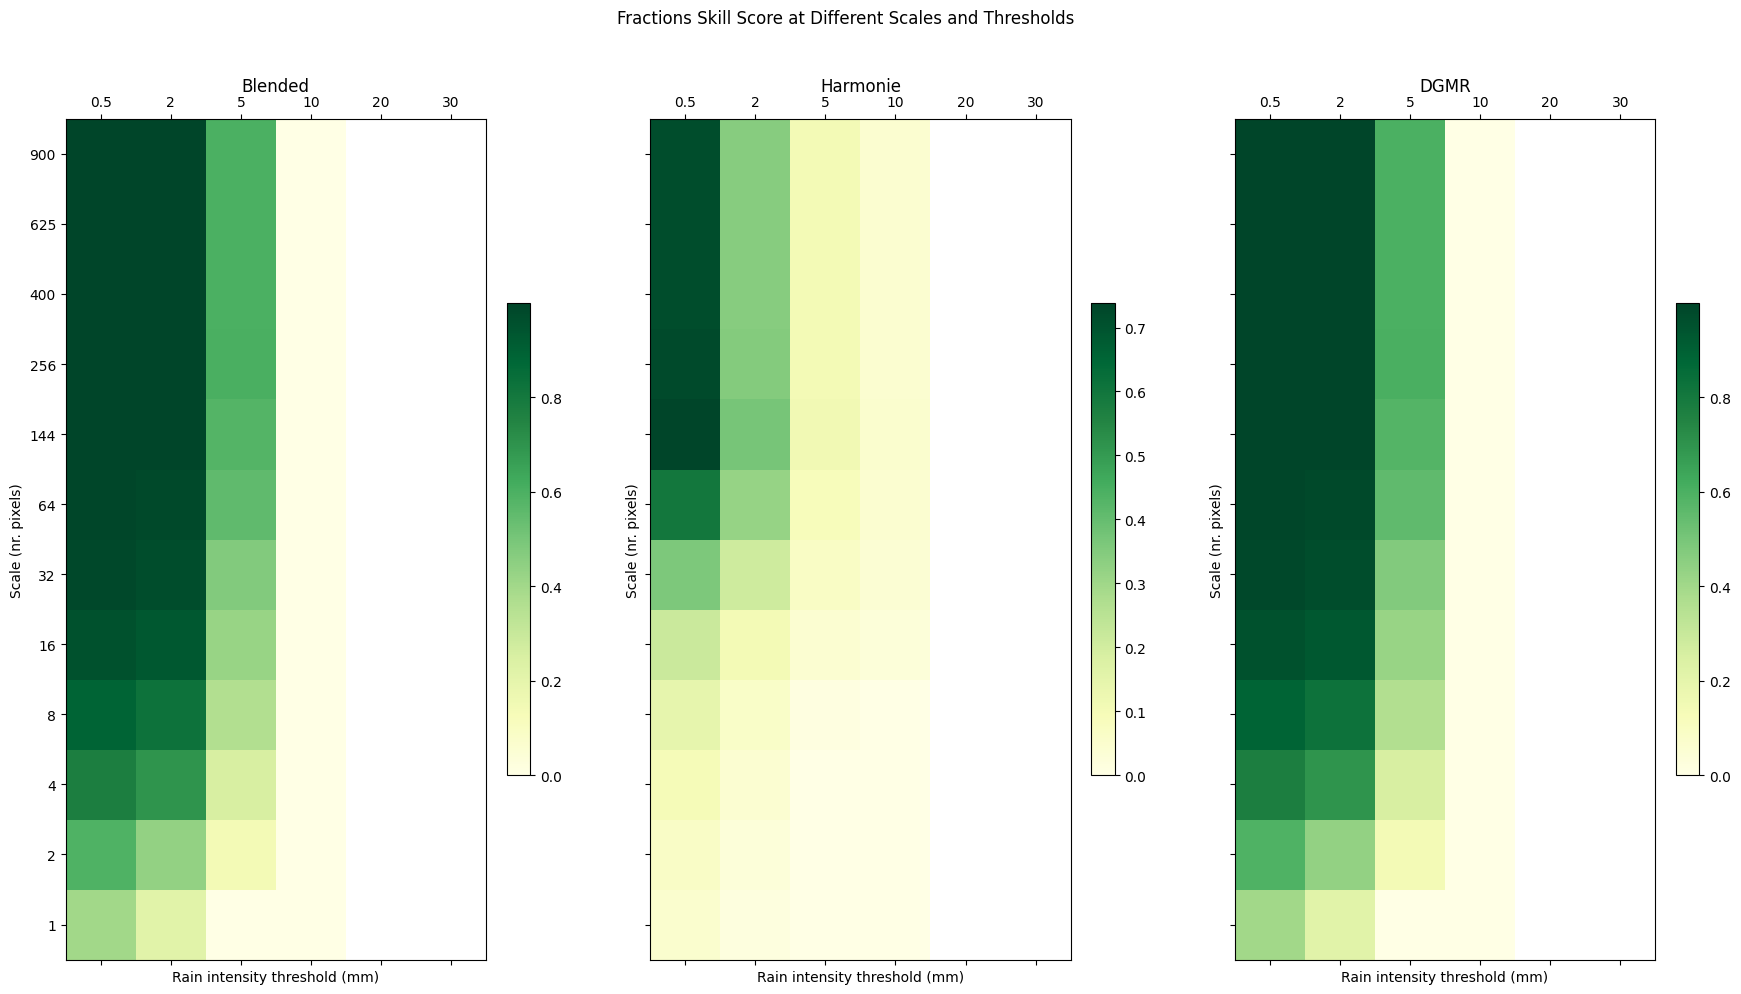

In [ ]:
datasets = ['precip_blended', 'nwp_all', 'DGMR_combined_extended_down']
fss_scores = {dataset: {scale: [] for scale in scales} for dataset in datasets}

# Compute FSS for each scale, threshold, and dataset
for scale in scales:
    for thr in thresholds:
        try:
            fss_scores['precip_blended'][scale].append(
                fss_method(precip_blended[0], KNMI_true[0], scale=scale, thr=thr)
            )
            fss_scores['nwp_all'][scale].append(
                fss_method(nwp_all[0], KNMI_true[0], scale=scale, thr=thr)
            )
            fss_scores['DGMR_combined_extended_down'][scale].append(
                fss_method(DGMR_combined_extended_down[0], KNMI_true[0], scale=scale, thr=thr)
            )
        except Exception as e:
            print(f"Error computing FSS for scale {scale} and threshold {thr}: {e}")

# Function to plot heatmap
def plot_heatmap(ax, data, title):
    cax = ax.matshow(data, cmap='YlGn', origin='lower')
    ax.set_title(title, pad=20)
    ax.set_xlabel('Rain intensity threshold (mm)')
    ax.set_ylabel('Scale (nr. pixels)')
    ax.set_xticks(np.arange(len(thresholds)))
    ax.set_xticklabels(thresholds)
    ax.set_yticks(np.arange(len(scales)))
    ax.set_yticklabels(scales)
    plt.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

# Prepare data for heatmaps
fss_data_blended = np.array([fss_scores['precip_blended'][scale] for scale in scales])
fss_data_combined = np.array([fss_scores['nwp_all'][scale] for scale in scales])
fss_data_dgmr = np.array([fss_scores['DGMR_combined_extended_down'][scale] for scale in scales])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharey=True)

# Plot heatmaps
plot_heatmap(axes[0], fss_data_blended, 'Blended')
plot_heatmap(axes[1], fss_data_combined, 'Harmonie')
plot_heatmap(axes[2], fss_data_dgmr, 'DGMR')

plt.suptitle('Fractions Skill Score at Different Scales and Thresholds')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Save scores

This part saves the pod, far and fss scores so that it can be used for further steps.

In [ ]:
import pickle

# Serialize the pod_scores dictionary to a file
with open(f'pod_scores_{startdatum}.pkl', 'wb') as f:
    pickle.dump(pod_scores, f)

# Download the file
google.colab.files.download(f'pod_scores_{startdatum}.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Serialize the far_scores dictionary to a file
with open(f'far_scores_{startdatum}.pkl', 'wb') as f:
    pickle.dump(far_scores, f)

# Download the file
google.colab.files.download(f'far_scores_{startdatum}.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Serialize the fss dictionary to a file
with open(f'fss_scores_{startdatum}.pkl', 'wb') as f:
    pickle.dump(fss_scores, f)

# Download the file
google.colab.files.download(f'fss_scores_{startdatum}.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>